### TODO

- ~~Create the AdaIN layer~~
- ~~Create the reverse VGG19 model to have the decoder, and make it trainable~~
- ~~Create a custom model~~
- ~~Create the loss function~~
- Automatically log the model and its hyperparameters on each training using MLFlow
--> Create a complete training pipeline : compile the model, fit it, log it (Add experiment and tags argument in the training function for the logging)
- ~~Create content and style datasets from the loaded images, with automatic image resizing pipeline for the training part (and eventually 256*256 window cropping)~~
- ~~Add getters and setters when required in AdaINDataModule (for train_val_test_split especially, maybe consider using the setattr method to handle all attributes at once)~~
- Add verbose steps for the training process
- ~~Create the AdaINTrainer~~
- Handle restart from checkpoint in AdaINTrainer
- Automatically clip the generated images to valid values

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import mlflow
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split
from torchvision import transforms

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import Loss
from keras.preprocessing import image, image_dataset_from_directory # type: ignore
from pathlib import Path

from adain_model import AdaINModel, instance_mean, instance_std, AdaINLoss
from adain_datamodule import AdaINDataModule

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..361.20508].


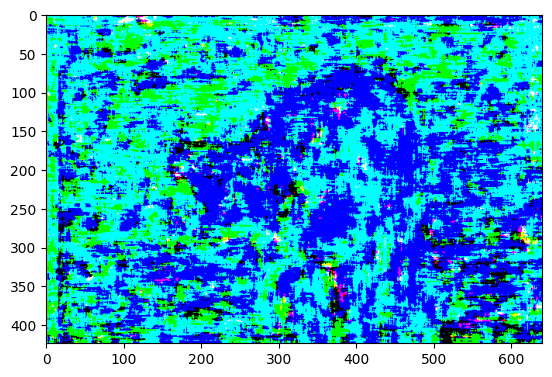

In [2]:
c = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/unlabeled2017/000000000013.jpg")))]))#.permute(1,2,0).to('cuda')
s = torch.tensor(np.array([keras.utils.img_to_array(image.load_img(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/Abstract_Expressionism/alice-baber_abstract-composition-1969.jpg")))]))#.permute(1,2,0).to('cuda')
a = AdaINModel()
o = a([c,s])
plt.imshow(o.clone().detach().cpu().numpy()[0])

# c.shape

In [ ]:
class AdaINTrainer() :
    def __init__(self, model : AdaINModel, data_module : AdaINDataModule, optimizer, mlflow_dir : Path = Path('./'), mlflow_tags : dict = {}) : #loss : AdaINLoss, optimizer) :
        self.model = model
        self.dm = data_module
        self.optimizer = optimizer
        self.mlflow_dir = mlflow_dir
        self.mlflow_tags = mlflow_tags

        self._prepared = False

    def _prepare(self) :
        print("Initiating datasets...")
        try :
            self.dm.create_datasets()
        except Exception as e :
            raise Exception(f"Could not create the datasets ({str(e)})") from None
        print("Compiling the model...")
        try :
            self.model.compile(optimizer=self.optimizer)#, loss=DummyLoss())
        except Exception as e :
            raise Exception(f"Could not compile the model ({str(e)})") from None
        
        mlflow.set_tracking_uri(self.mlflow_dir)
        mlflow.set_experiment("AdaIN Style Transfer")
        self._prepared = True
        print("Model is ready to be trained")
    
    def train(self, epochs = 1) 
        if not self._prepared :
            self._prepare()
        print("Training the model...")
        mlflow.keras.autolog(extra_tags=self.mlflow_tags)
        self.model.fit(self.dm.train_dataloader(), validation_data=self.dm.val_dataloader(), epochs=epochs)
        self.model.evaluate(self.dm.test_dataloader())
        # with mlflow.start_run():
        #     mlflow.set_tags(self.mlflow_tags)
        #     mlflow.log_params(self.model.params)
        print("The training is complete ! The model and its performances have been logged in MLFlow")

In [4]:
dm = AdaINDataModule(Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/unlabeled2017/"), Path("D:/StyleTransferAI/StyleTransferAI_AdaIN/datasets/WikiArt/"), dataset_size=100, seed=444, batch_size=8)
model = AdaINModel()

trainer = AdaINTrainer(model, dm, 'adam', mlflow_dir=Path("D:/Python/ML Flow/mlruns"), mlflow_tags={"Debugging" : True})
trainer.train()

Initiating datasets...
Compiling the model...
Model is ready to be trained
Training the model...


2025/03/05 17:44:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '63e962fb2be744209f858ea5fb645195', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
2025/03/05 17:44:51 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'torch.utils.data.dataloader.DataLoader'>. Dataset logging skipped.
2025/03/05 17:44:51 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'torch.utils.data.dataloader.DataLoader'>. Dataset logging skipped.


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 612ms/step - loss: 8847.0381 - val_loss: 7426.3735


2025/03/05 17:44:58 WARNING mlflow.keras.autologging: Failed to get model signature, reason: 'AdaINModel' object has no attribute 'input_shape'
2025/03/05 17:44:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/05 17:45:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/05 17:45:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 7684.7896
The training is complete ! The model and its performances have been logged in MLFlow


In [5]:
model.summary()

Model: "ada_in_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg_encoder_1 (VGGEncoder)      │ ?                      │     3,505,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ada_in_layer_1 (AdaINLayer)     │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg_decoder_1 (VGGDecoder)      │ ?                      │     3,505,219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,021,387 (53.49 MB)

 Trainable params: 3,505,219 (13.37 MB)

 Non-trainable params: 3,505,728 (13.37 MB)

 Optimizer params: 7,010,440 (26.74 MB)